# Building up tools to analyse a 2-D problem

> Code for a 2-D problem.

In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.tri as tri
plt.rcParams['figure.figsize'] = (10,6)
import sympy; sympy.init_printing()
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))

## 2 dimensional case (PDE)

We consider the following 2-D problem:

$$\nabla\cdot\left(\kappa(x)\nabla u(x)\right)=f(x) \quad\forall x\in D=[0,1]^{2}$$

$$u(x)=0\quad\forall x\in\partial D$$

where here $f$ is again a random forcing term, assumed to be a GP in this work.

### Variational formulation

The variational formulation is given by:

$$a(u,v)=L(v)$$

where:

$$a(u,v)=\int_{D}\nabla u\cdot\left(\kappa\nabla u\right)dx$$

and

$$L(v)=\int_{D}fvdx$$

We will make the following choices for $\kappa,f$:

$$\kappa(x)=1$$

$$f\sim\mathcal{G}\mathcal{P}(\bar{f},k_{f})$$

$$\bar{f}(x)=1$$

$$ k_{f}(x,y) = \sigma_f^{2}\exp\left(-\frac{\|x-y\|^2}{2l_f^2}\right)$$

$$ \sigma_{f} = 0.1$$

$$ l_f = 0.4 $$

where $\|\cdot\|$ is the usual Euclidean norm.

Since we do not have access to a suitable Green's function for this problem, we will have to estimate the rate of convergence of the statFEM prior and posterior by comparing them on a sequence of refined meshes. More details on this will follow later. Thus, we need similar code as for the 1-D problem.

### statFEM prior mean

We will again utilise FEniCS to obtain the statFEM prior mean. For this purpose, we create a function [mean_assembler()](statFEM_analysis.rst#statFEM_analysis.twoDim.mean_assembler) which will assemble the mean for the statFEM prior.

In [2]:
from statFEM_analysis.twoDim import mean_assembler

`mean_assembler` takes in the mesh size `h` and the mean function `f_bar` for the forcing and computes the mean of the approximate statFEM prior, returning this as a FEniCS function.

<div class="alert alert-warning">
    
Important:
    
`mean_assembler` requires `f_bar` to be represented as a FEniCS function/expression/constant.
    
</div>

Let's check that this is working:

In [3]:
h = 0.1
f_bar = Constant(1.0)
μ = mean_assembler(h,f_bar)
μ

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 1), FiniteElement('Lagrange', triangle, 1)), 9)

In [4]:
# check the type of μ
assert type(μ) == function.function.Function

Let's plot $\mu$:

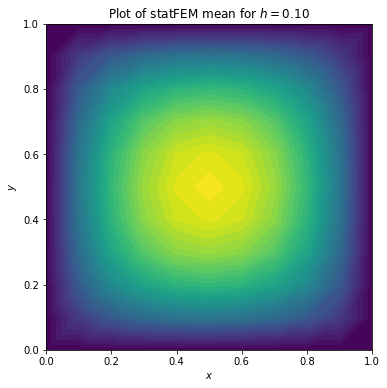

In [5]:
# use FEniCS to plot μ
plot(μ)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Plot of statFEM mean for $h=%.2f$'%h)
plt.show()

### statFEM prior covariance

We will also utilise FEniCS again to obtain an approximation of our statFEM covariance function.

The statFEM covariance can be approximated as follows:

$$c_u^{\text{FEM}}(x,y)\approx\sum_{i,j=1}^{J}\varphi_{i}(x)Q_{ij}\varphi_{j}(y)$$

where $Q=A^{-1}MC_{f}M^{T}A^{-T}$ and where the $\{\varphi_{i}\}_{i=1}^{J}$ are the FE basis functions corresponding to the interior nodes of our domain.

with $C_f$ being the kernel matrix of $f$ (evaluated on the FEM grid).

As we will be comparing the statFEM covariance functions for finer and finer FE mesh sizes we will need to be able to assemble the statFEM covariance function on a grid. As discussed in <a href="/statFEM/oneDim.html#Difference-between-true-prior-covariance-and-statFEM-prior-covariance"><code>oneDim</code></a>, we can assemble such covariance matrices in a very efficient manner. The code remains largely the same as in the 1-D case and so we do not go into as much detail here.

We start by creating a function [kernMat()](statFEM_analysis.rst#statFEM_analysis.twoDim.kernMat) which assembles the covariance matrix corresponding to a covariance function `k` on a grid `grid`.

In [6]:
from statFEM_analysis.twoDim import kernMat

<div class="alert alert-info">

Note:

This function takes in two optional boolean arguments `parallel` and `translation_inv`. The first of these specifies whether or not the cov matrix should be computed in parallel and the second specifies whether or not the cov kernel is translation invariant. If it is, the covariance matrix is computed more efficiently using the `cdist` function from scipy.

</div>

Let's quickly test if this function is working, by computing the cov matrix for white noise, which has kernel function $k(x,y)=\delta(x-y)$. For a grid of length $N$ this should be the $N\times N$ identity matrix.

In [7]:
# set up the kernel function
# set up tolerance for comparison
tol = 1e-16
def k(x,y):
    if (np.abs(x-y) < tol).all():
        # x == y within the tolerance
        return 1.0
    else:
        # x != y within the tolerance
        return 0.0

# set up grid
n = 21
x_range = np.linspace(0,1,n)
grid = np.array([[x,y] for x in x_range for y in x_range])
N = len(grid) # get length of grid (N=n^2)
K = kernMat(k,grid,True,False) # parallel mode

# check that this is the N x N identity matrix
assert (K == np.eye(N)).all()

We now create a function [BigPhiMat()](statFEM_analysis.rst#statFEM_analysis.twoDim.BigPhiMat) to utilise FEniCS to efficiently compute the matrix $\boldsymbol{\Phi}$ defined above.

In [8]:
from statFEM_analysis.twoDim import BigPhiMat

`BigPhiMat` takes in two arguments: `J`, which controls the FE mesh size ($h=1/J^{2}$), and `grid` which is the grid in the definition of $\boldsymbol{\Phi}$. `BigPhiMat` returns $\boldsymbol{\Phi}$ as a sparse `csr_matrix` for memory efficiency.

<div class="alert alert-info">

Note:

Since FEniCS works with the FE functions corresponding to all the FE dofs and our matrix $\Sigma_2$ only uses the FE functions corresponding to non-boundary dofs we need to account for this in the code. See the source code for `BigPhiMat` to see how this is done.
    
</div>

We now create a function [cov_asssembler()](statFEM_analysis.rst#statFEM_analysis.twoDim.cov_assembler) which assembles the approximate FEM covariance matrix on the grid.

In [9]:
from statFEM_analysis.twoDim import cov_assembler

`cov_assembler` takes in several arguments which are explained below:

- `J`: controls the FE mesh size ($h=1/J^{2})$
- `k_f`: the covariance function for the forcing $f$
- `grid`: the reference grid where the FEM cov matrix should be computed on
- `parallel`: boolean argument indicating whether the intermediate computation of $C_f$ should be done in parallel 
- `translation_inv`: boolean argument indicating whether the intermediate computation of $C_f$ should be computed assuming `k_f` is translation invariant or not

As a quick demonstration that the code is working, we will the statFEM cov matrix for a relatively coarse grid.

In [10]:
# set up kernel function for forcing
f_bar = Constant(1.0)

l_f = 0.4
σ_f = 0.1

def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

# set up grid
n = 21
x_range = np.linspace(0,1,n)
grid = np.array([[x,y] for x in x_range for y in x_range])

# get the statFEM grid for a particular choice of J
J = 10
Σ = cov_assembler(J,k_f,grid,False,True)

Let's plot a heatmap of the statFEM cov matrix:

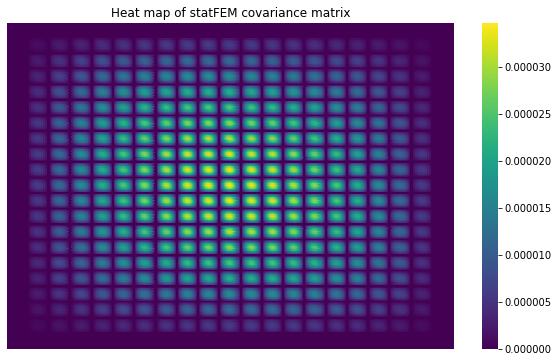

In [11]:
sns.heatmap(Σ,cbar=True,
              annot=False,
              xticklabels=False,
              yticklabels=False,
              cmap=cm.viridis)
plt.title('Heat map of statFEM covariance matrix')
plt.show()

<div class="alert alert-info">
    
Note:
    
The banded structure in the above statFEM covariance matrix is due to the internal ordering of the FE grid in FEniCS.

</div>

### statFEM posterior mean

The statFEM posterior from incorporating sensor readings has the same form as given in [oneDim](00_oneDim.ipynb#Posterior-from-incorporating-sensor-readings). We will thus require very similar code as to the 1-D case. We start by creating a function [m_post()](statFEM_analysis.rst#statFEM_analysis.twoDim.m_post) which evaluates the posterior mean at a given point.

In [12]:
from statFEM_analysis.twoDim import m_post

`m_post` takes in several arguments which are explained below:

- `x`: point where the posterior mean will be evaluated
- `m`: function which computes the prior mean at a given point y
- `c`: function which returns the vector (c(x,y)) for y in Y (note: c is the prior covariance function)
- `v`: vector of noisy sensor readings
- `Y`: vector of sensor locations
- `B`: the matrix $\epsilon^{2}I+C_Y$ to be inverted in order to obtain the posterior

We now require code to generate samples from a GP with mean $m$ and cov function $k$ on a grid. We write the function [sample_gp()](statFEM_analysis.rst#statFEM_analysis.twoDim.sample_gp) for this purpose.

In [13]:
from statFEM_analysis.twoDim import sample_gp

`sample_gp` takes in several arguments which are explained below:

- `n_sim`: number of trajectories to be sampled
- `m`: mean function for the GP
- `k`: cov function for the GP
- `grid`: grid of points on which to sample the GP
- `par`: boolean argument indicating whether the computation of the cov matrix should be done in parallel
- `trans`: boolean argument indicating whether the computation of the cov matrix should be computed assuming `k` is translation invariant or not
- `tol`: controls the size of the tiny diagonal perturbation added to cov matrix to ensure it is strictly positive definite (defaults to `1e-9`)

As a quick demonstration that the code is working lets generate 2 realisations of white noise, using the kernel `k` from one of the previous tests and plot a heatmap of these random fields side-by-side.

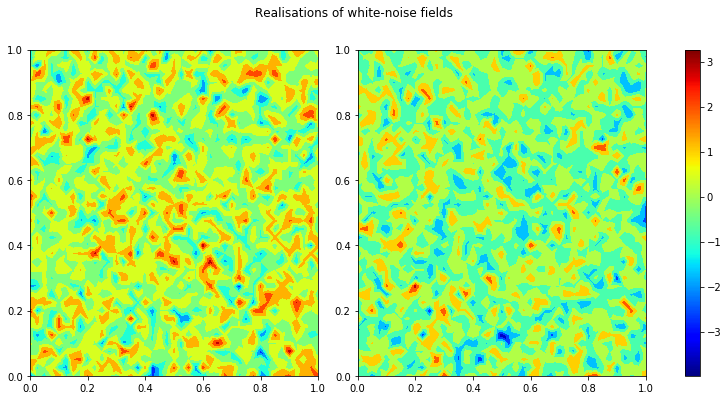

In [14]:
n = 41
x_range = np.linspace(0,1,n)
grid = np.array([[x,y] for x in x_range for y in x_range])

# set up mean
def m(x):
    return 0.0

np.random.seed(23534)
samples = sample_gp(2,m,k,grid,True,False)

sample_1 = samples[:,0].flatten()
sample_2 = samples[:,1].flatten()

vmin = min(sample_1.min(),sample_2.min())
vmax = max(sample_1.max(),sample_2.max())
cmap = cm.jet
norm = colors.Normalize(vmin=vmin,vmax=vmax)

x = grid[:,0].flatten()
y = grid[:,1].flatten()
triang = tri.Triangulation(x,y)

plt.rcParams['figure.figsize'] = (12,6)
fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,4,0.2]))
axs[0].tricontourf(triang,sample_1.flatten(),cmap=cmap)
axs[1].tricontourf(triang,sample_2.flatten(),cmap=cmap)
cb = colorbar.ColorbarBase(axs[2],cmap=cmap,norm=norm)
fig.suptitle('Realisations of white-noise fields')
plt.show()

Let's also quickly generate 2 realisations for the kernel `k_f` above:

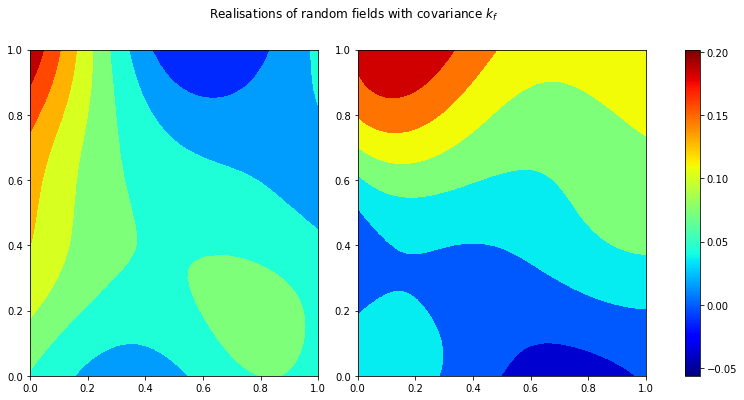

In [15]:
np.random.seed(534)
samples = sample_gp(2,m,k_f,grid,False,True)

sample_1 = samples[:,0].flatten()
sample_2 = samples[:,1].flatten()

vmin = min(sample_1.min(),sample_2.min())
vmax = max(sample_1.max(),sample_2.max())
cmap = cm.jet
norm = colors.Normalize(vmin=vmin,vmax=vmax)

x = grid[:,0].flatten()
y = grid[:,1].flatten()
triang = tri.Triangulation(x,y)

plt.rcParams['figure.figsize'] = (12,6)
fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,4,0.2]))
axs[0].tricontourf(triang,sample_1.flatten(),cmap=cmap)
axs[1].tricontourf(triang,sample_2.flatten(),cmap=cmap)
cb = colorbar.ColorbarBase(axs[2],cmap=cmap,norm=norm)
fig.suptitle(r'Realisations of random fields with covariance $k_f$')
plt.show()

The next bit of code we require is code to generate noisy sensor readings from our system. We write the function [gen_sensor()](statFEM_analysis.rst#statFEM_analysis.twoDim.gen_sensor) for this purpose.

In [16]:
from statFEM_analysis.twoDim import gen_sensor

`gen_sensor` takes in several arguments which are explained below:

- `ϵ`: controls the amount of sensor noise
- `m`: mean function for the forcing f
- `k`: cov function for the forcing f
- `Y`: vector of sensor locations
- `J`: controls the FE mesh size ($h=1/J^{2}$)
- `par`: boolean argument indicating whether the computation of the forcing cov matrix should be done in parallel
- `trans`: boolean argument indicating whether the computation of the forcing cov matrix should be computed assuming `k` is translation invariant or not
- `tol`: controls the size of the tiny diagonal perturbation added to forcing cov matrix to ensure it is strictly positive definite (defaults to `1e-9`)
- `require` : boolean argument indicating whether or not to also return the realisation of the forcing `f_sim` and the FEniCS solution `u_sol` (defaults to `False`)

<div class="alert alert-warning">

Warning:

Since we do not have access to the true solution we must use FEniCS to get the solution for our system. Thus, one must choose a small enough `J` in `gen_sensor` above to ensure we get realistic noisy sensor readings.
    
</div>

Let's demonstrate that this code is working, by generating $s=25$ sensor observations with the sensors equally space in the domain $D$.

In [17]:
# set up mean function for forcing
def m_f(x):
    return 1.0

# set up sensor grid and sensor noise level
ϵ = 0.2
s = 25
s_sqrt = int(np.round(np.sqrt(s)))
Y_range = np.linspace(0.01,0.99,s_sqrt)
Y = np.array([[x,y] for x in Y_range for y in Y_range])
J_fine = 100 # FE mesh size to compute solution on

# generate the sensor observations
np.random.seed(235)
v_dat = gen_sensor(ϵ,m_f,k_f,Y,J_fine,False,True)

The next bit of code needed in order to compute the difference between the posterior means is a way of comparing the two different mean functions. One possible solution is to overload the `UserExpression` class in FEniCS to create custom FEniCS expressions from user defined functions. This will allow us to use our function `m_post` together with `errornorm` from FEniCS to compute the L2 norm of the difference. We thus, create a class called [MyExpression()](statFEM_analysis.rst#statFEM_analysis.twoDim.MyExpression).

In [18]:
from statFEM_analysis.twoDim import MyExpression

We now require code which will create the matrix $C_Y,h$ and the function $\mathbf{c}^{(h)}$ required for the statFEM posterior mean. We will create the function [fem_cov_assembler_post()](statFEM_analysis.rst#statFEM_analysis.twoDim.fem_cov_assembler_post) for this purpose. 

In [19]:
from statFEM_analysis.twoDim import fem_cov_assembler_post

`fem_cov_assembler_post` takes in several arguments which are explained below:

- `J`: controls the FE mesh size ($h=1/J^2$)
- `k_f`: the covariance function for the forcing $f$
- `Y`: vector of sensor locations
- `parallel`: boolean argument indicating whether the computation of the forcing cov mat should be done in parallel
- `translation_inv`: boolean argument indicating whether the computation of the forcing cov mat should be computed assuming `k_f` is translation invariant or not

With all of this code in place we can now finally write the function [m_post_fem_assmebler()](statFEM_analysis.rst#statFEM_analysis.twoDim.m_post_fem_assembler) which will assemble the statFEM posterior mean function.

In [20]:
from statFEM_analysis.twoDim import m_post_fem_assembler

`m_post_fem_assembler` takes in several arguments which are explained below:

- `J`: controls the FE mesh size ($h=1/J^{2}$)
- `f_bar`: the mean function for the forcing $f$
- `k_f`: the covariance function for the forcing $f$
- `ϵ`: controls the amount of sensor noise
- `Y`: vector of sensor locations
- `v_dat`: vector of noisy sensor observations
- `par`: boolean argument passed to `fem_cov_assembler_post`'s argument `parallel` (defaults to `False`)
- `trans`: boolean argument passed to `fem_cov_assembler_post`'s argument `translation_inv` (defaults to `True`)

Let's quickly check that this function is working.

In [21]:
J = 20
f_bar = Constant(1.0)
m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
# compute posterior mean at a location x in D
x = np.array([0.3,0.1])
m_post_fem(x)

### statFEM posterior covariance

The form of the statFEM posterior covariance remains the same as given in [oneDim](00_oneDim.ipynb#Posterior-covariance). Thus, we require very similar code as to the 1-D case. We start by creating a function [c_post()](statFEM_analysis.rst#statFEM_analysis.twoDim.c_post) which evaluates the posterior covariance at a given point.

In [22]:
from statFEM_analysis.twoDim import c_post

`c_post` takes in several arguments which are explained below:

- `x`,`y`: points to evaluate the covariance at
- `c`: function which returns the prior covariance at any given pair $(x,y)$
- `Y`: vector of sensor locations
- `B`: the matrix $\epsilon^{2}I+C_{Y}$ to be inverted in order to obtain the posterior

To compare the statFEM covariance matrices for finer and finer FE mesh sizes we will require some more code. First we create a function [post_fem_cov_assembler()](statFEM_analysis.rst#statFEM_analysis.twoDim.post_fem_cov_assembler) which helps us to quickly assemble the statFEM posterior covariance matrix as explained in [oneDim](00_oneDim.ipynb#Difference-between-posterior-covariances).

In [23]:
from statFEM_analysis.twoDim import post_fem_cov_assembler

`post_fem_cov_assembler` takes in several arguments which are explained below:

- `J`: controls the FE mesh size ($h=1/J^2$)
- `k_f`: the covariance function for the forcing $f$
- `grid`: the fixed reference grid $\{x_{i}\}_{i=1}^{N}$ on which to assemble the posterior cov mat
- `Y`: vector of sensor locations.
- `parallel`: boolean argument indicating whether the computation of the forcing cov mat should be done in parallel
- `translation_inv`: boolean argument indicating whether the computation of the forcing cov mat should be computed assuming `k_f` is translation invariant or not

Finally, we create the function [c_post_fem_assembler()](statFEM_analysis.rst#statFEM_analysis.twoDim.c_post_fem_assembler) which assembles the statFEM posterior cov mat on the reference grid using the matrices `post_fem_cov_assembler` returns.

In [24]:
from statFEM_analysis.twoDim import c_post_fem_assembler